In [1]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pylab as plt

from monteloanco import Model, GroupedBatchSampler

# Read data

In [2]:
df_jsonl = pd.read_json('accepted_2007_to_2018Q4.jsonl.gz', lines=True).set_index('id')

In [3]:
df = pd.read_csv('monteloanco.csv.gz', index_col='id')
df = df.join(df_jsonl, how='inner').reset_index()

In [4]:
df.installment = df.installment.apply(torch.tensor)
df.pymnt = df.pymnt.apply(torch.tensor)

# Read model

In [5]:
model = Model(embedding_size=4, input_size=len(df), device='cpu')
model.load_state_dict(torch.load('monteloanco.pt', weights_only=True))

<All keys matched successfully>

# Perform test simulation

In [6]:
row = df.sample(1).squeeze()
print(row)
hidden_states, sim_pymnts, interst_payments, principal_payments = model.forward(
    batchidx=0,
    idx=torch.tensor(row.name).repeat(100), 
    installments=row.installment.repeat(100),
    loan_amnt=torch.tensor(row.loan_amnt).repeat(100), 
    int_rate=torch.tensor(row.int_rate).repeat(100))

id                                                      135825601
0                                                        0.242572
1                                                         0.35098
2                                                       -0.853042
3                                                        -1.30543
                                      ...                        
term_numeric                                                   36
installment                                      tensor(530.7700)
loan_amnt                                                   15000
int_rate                                                    16.46
pymnt           [tensor(529.0550), tensor(529.0550), tensor(52...
Name: 59694, Length: 71, dtype: object


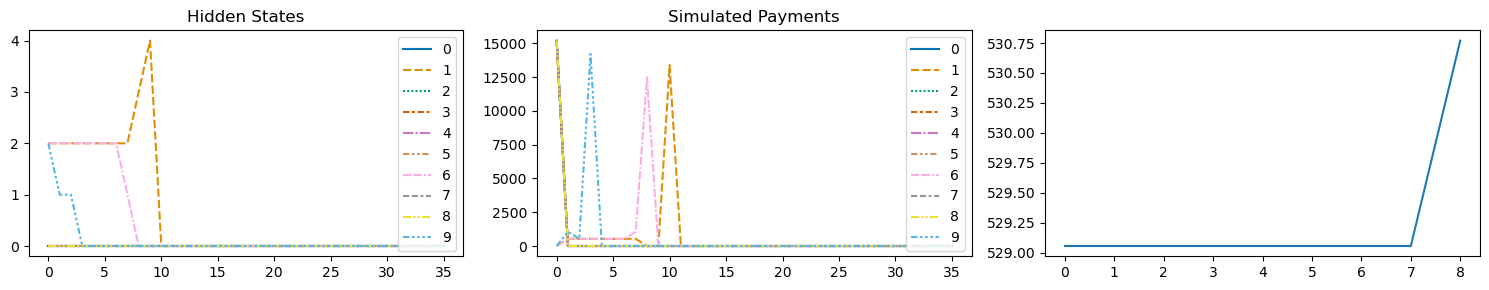

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
sns.lineplot(hidden_states.detach().numpy()[:,:10], ax=ax[0], palette='colorblind')
sns.lineplot(sim_pymnts.detach().numpy()[:,:10], ax=ax[1], palette='colorblind')
sns.lineplot(row.pymnt, ax=ax[2])
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Simulated Payments")
plt.tight_layout()
plt.show()

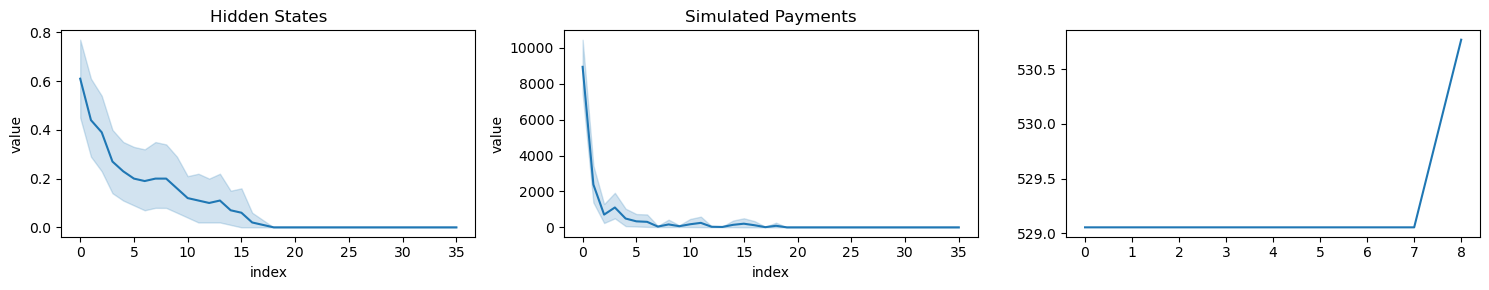

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
sns.lineplot(pd.DataFrame(hidden_states.detach().numpy()).reset_index().melt(id_vars='index'), x='index', y='value', errorbar=('ci', 95), ax=ax[0])
sns.lineplot(pd.DataFrame(sim_pymnts.detach().numpy()).reset_index().melt(id_vars='index'), x='index', y='value', errorbar=('ci', 95), ax=ax[1])
sns.lineplot(row.pymnt, ax=ax[2])
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Simulated Payments")
plt.tight_layout()
plt.show()

# Simulate full dataset

In [9]:
batch_size = 100_000
dataset = df[['id', 'installment', 'pymnt', 'loan_amnt', 'int_rate']].reset_index(names='idx').to_dict(orient='records')
grouped_batch_sampler = GroupedBatchSampler(dataset, batch_size)

In [10]:
from torch.utils.data import DataLoader

In [11]:
batches = [] 
for batchidx, batch in enumerate(DataLoader(dataset, batch_sampler=grouped_batch_sampler, num_workers=1)):
    batches.append(model.forward(batchidx, batch['idx'], batch['installment'], batch['loan_amnt'], batch['int_rate'], batch['pymnt']))
hidden_states, sim_pymnts, interst_payments, principal_payments = zip(*batches)
#hidden_states = torch.concat(hidden_states, axis=-1)
#sim_pymnts = torch.concat(sim_pymnts, axis=-1)

In [12]:
from itertools import chain

s_sim_pymnts = pd.Series(torch.concat([x.sum(axis=0) for x in sim_pymnts]), index=chain.from_iterable(grouped_batch_sampler.batches))
s_sim_pymnts

0         4197.060059
95       10055.583008
109      12334.867188
137        445.500000
156      26174.230469
             ...     
97688    10761.672852
97823    37204.058594
98082    34274.746094
98265    18175.050781
99332    15583.613281
Length: 99877, dtype: float32

In [13]:
s_sim_pymnts.sum()

1511023900.0

# Score distributions

In [14]:
tmat = model._idx_to_tmat(
    torch.arange(dataset.__len__()), 
    batch_size=dataset.__len__())

In [15]:
def tmat_to_score(tmat):
    '''
    Function to identify probability of account being up to date after 12 months
    '''
    score = torch.zeros(8)
    score[1] = 1.
    for _ in range(12): score = torch.matmul(score, tmat)
    return score

scores = torch.vmap(tmat_to_score)(tmat)[(torch.arange(len(tmat)), 7)]

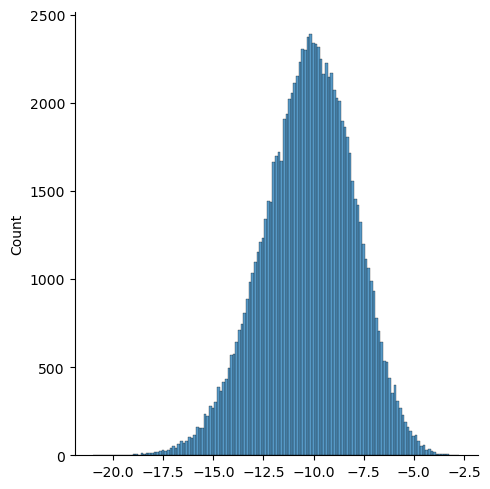

In [16]:
from scipy.special import logit

sns.displot(logit(scores.detach().numpy()), kind='hist')

In [17]:
df['pymnt_sum'] = [x.sum().item() for x in df.pymnt]
df = df.join(s_sim_pymnts.rename('sim_pymnts_sum'))

In [18]:
df['pd_qcut'] = pd.qcut(df.pd, q=11)
df.groupby('pd_qcut', observed=False)[['pymnt_sum', 'sim_pymnts_sum']].sum()

,pymnt_sum,sim_pymnts_sum
pd_qcut,,
"(-0.000999999502, 1.6e-06]",1.102166e+08,137811808.0
"(1.6e-06, 4.51e-06]",1.083708e+08,137942432.0
"(4.51e-06, 9.33e-06]",1.092570e+08,138140944.0
"(9.33e-06, 1.72e-05]",1.090031e+08,137302976.0
"(1.72e-05, 2.97e-05]",1.078850e+08,136914240.0
"(2.97e-05, 4.97e-05]",1.093392e+08,138248352.0
"(4.97e-05, 8.4e-05]",1.065449e+08,136825472.0
"(8.4e-05, 0.000148]",1.077830e+08,136327488.0
"(0.000148, 0.000279]",1.085596e+08,137093072.0
